In [80]:
import h5py
import math
import random
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
matplotlib.rcParams['axes.unicode_minus']=False

In [81]:
# 一些全局变量，放在这里好设置
# 说白了就是可以在合理范围之内改动的参数

# SHM-Data的位置
SHM_Data_Locate = "D://SHM-Data/"

# 连续小波变换的输入宽度
# 对现在用的SHM-Data来说够了，改大了就是徒增计算量
tof_widths = 101

# CF/RP板材的大小(mm)
# 没啥用，哈哈哈
plant_size = [500, 500]

# 12组传感器的xy坐标
sensor_locate = np.array([[450, 470], [370, 470], [290, 470], [210, 470], [130, 470], [50, 470], [450, 30], [370, 30], [290, 30], [210, 30], [130, 30], [50, 30]])

# 28个缺陷的位置
damage_locate = np.array([
    [50, 415], [65, 415], [50, 400], [65, 400],
    [250, 427], [265, 427], [250,412], [265, 412],
    [180, 345], [195, 345], [180,330], [195, 345],
    [320, 275], [335, 275], [320, 260], [335, 275],
    [130, 195], [145, 195], [130, 180], [130, 180],
    [435, 205], [450, 205], [435, 190], [450, 190],
    [250, 90], [265, 90], [250, 75], [265, 75]
])

# 选用的baseline
SHM_Data_baseline = '20180604T164628_baseline_1/pc_f100kHz.h5'

# MCMC总运行次数
# 越大越准，越大计算越慢
NT = 10000

# MCMC老化时间
# 只要你NT设置的足够大，老化时间是可以忽略的，可惜我懒得等计算
NB = 150

# 先验概率密度函数
# 正态分布的参数
[def_p_x, def_p_y, def_p_v] = [400, 400, 2000]
[def_p_x_scale, def_p_y_scale, def_p_v_scale] = [10, 10, 100]

In [82]:
locate = "20180605T150315_D9/pc_f100kHz.h5"
select = np.array([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11]])

In [83]:
dmt_file = h5py.File(SHM_Data_Locate + locate, 'r')
dmt_catch = dmt_file['/pitchcatch/catch']
dmt_signal = dmt_file['/pitchcatch/pitch']
dmt_catch = dmt_catch[()][11, :]
dmt_signal = dmt_signal[()][11, :]

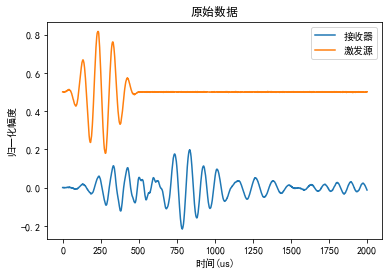

In [84]:
x1 = np.linspace(0, 13107, 13108)
x2 = np.linspace(0, 2000, 2001)
fig, ax = plt.subplots()
ax.set_title('原始数据')
ax.plot(x2, dmt_catch[0:2001], label='接收器')
ax.plot(x2, (dmt_signal[0:2001]/300+0.5), label='激发源')
ax.set_xlabel('时间(us)')
ax.set_ylabel('归一化幅度')
ax.legend()
plt.show()

In [85]:
widths = np.arange(1, tof_widths)
dmt_catch_cwt = signal.cwt(dmt_catch, signal.morlet2, widths)
dmt_signal_cwt = signal.cwt(dmt_signal, signal.morlet2, widths)
dmt_catch_cwt = np.square(np.abs(dmt_catch_cwt))
dmt_signal_cwt = np.square(np.abs(dmt_signal_cwt))

dmt_catch_cwt_x, dmt_catch_cwt_y = np.where(dmt_catch_cwt == np.max(dmt_catch_cwt))
dmt_catch_cwt = dmt_catch_cwt[dmt_catch_cwt_x, :]
dmt_catch_cwt.resize(13108)

dmt_signal_cwt_x, dmt_signal_cwt_y = np.where(dmt_signal_cwt == np.max(dmt_signal_cwt))
dmt_signal_cwt = dmt_signal_cwt[dmt_signal_cwt_x, :]
dmt_signal_cwt.resize(13108)

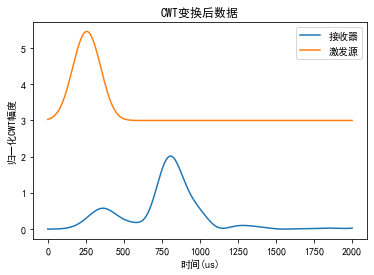

In [94]:
fig, ax = plt.subplots()
ax.set_title('CWT变换后数据')
ax.plot(x2, dmt_catch_cwt[0:2001], label='接收器')
ax.plot(x2, (dmt_signal_cwt[0:2001]/180000+3), label='激发源')
ax.set_xlabel('时间(us)')
ax.set_ylabel('归一化CWT幅度')
ax.legend()
plt.show()